In [86]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit
from pandas.tseries.offsets import DateOffset
import json
from datetime import datetime
import copy
import warnings
import wandb
import os
warnings.filterwarnings('ignore')
os.environ["WANDB_SILENT"] = "true"

In [87]:
%load_ext autoreload
%autoreload 2
from models.models import HoltWintersWrapper, ProphetWrapper


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
cpi = pd.read_csv('cpi.csv')
fuel = json.load(open('fuel.json'))
sabor_df = pd.read_csv('sabor.csv')
currency = pd.read_csv('currency_data.csv')
credit = pd.read_excel('credit.xlsx', header=1)
jse = pd.read_csv('jse_indices.csv')

In [89]:
cpi_columns = list(cpi.columns[2:-1])

In [90]:
#cpi_columns = ["Transport"]

In [91]:
fuel_table = {}
for entry in fuel['LRP 95 Coast']:
    fuel_table[list(entry.keys())[0]] = list(entry.values())[0]

In [92]:
fuel_df = pd.DataFrame(fuel_table.items(), columns=['date', 'fuel_price'])

In [93]:
fuel_df.to_csv('fuel_df.csv')

In [94]:
fuel_df['date'] = fuel_df['date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d').strftime('%Y-%m'))

currency['Date'] = currency['Date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d').strftime('%Y-%m'))

currency = currency.groupby('Date').mean().reset_index()

In [95]:
fuel_offeset_df = fuel_df.copy()
fuel_offeset_2_df = fuel_df.copy()
fuel_offeset_3_df = fuel_df.copy()

In [96]:
fuel_offeset_df['date'] = pd.to_datetime(fuel_offeset_df['date']) + pd.DateOffset(months=1)
fuel_offeset_df['date'] = fuel_offeset_df['date'].map(lambda x: x.strftime('%Y-%m'))
fuel_offeset_df.dropna(inplace=True)

In [97]:
fuel_offeset_2_df['date'] = pd.to_datetime(fuel_offeset_2_df['date']) + pd.DateOffset(months=2)
fuel_offeset_2_df['date'] = fuel_offeset_2_df['date'].map(lambda x: x.strftime('%Y-%m'))
fuel_offeset_2_df.dropna(inplace=True)

In [98]:
fuel_offeset_3_df['date'] = pd.to_datetime(fuel_offeset_3_df['date']) + pd.DateOffset(months=3)
fuel_offeset_3_df['date'] = fuel_offeset_3_df['date'].map(lambda x: x.strftime('%Y-%m'))
fuel_offeset_3_df.dropna(inplace=True)

In [99]:
fuel_offeset_df[fuel_offeset_df['date'] == '2021-10']

,date,fuel_price
23,2021-10,17.63


In [100]:
fuel_df

,date,fuel_price
0,2023-07,21.34
1,2023-06,21.58
2,2023-05,22.29
3,2023-04,21.92
4,2023-03,22.00
...,...,...
180,2008-05,9.29
181,2008-04,8.74
182,2008-03,8.07
183,2008-02,7.46


In [101]:
cpi = pd.merge(cpi,fuel_df, on="date")
cpi = pd.merge(cpi,sabor_df, on="date")

In [102]:
merged_df = pd.merge(fuel_df, sabor_df, on='date', how='left')

In [103]:
currency

,Date,USD/ZAR,GBP/ZAR,EUR/ZAR
0,2018-01,12.197131,16.812471,14.852223
1,2018-02,11.818639,16.556277,14.617775
2,2018-03,11.843666,16.529828,14.597329
3,2018-04,12.067608,16.989794,14.818127
4,2018-05,12.513433,16.881612,14.814248
...,...,...,...,...
61,2023-02,17.916716,21.611035,19.168071
62,2023-03,18.264031,22.163418,19.565940
63,2023-04,18.156630,22.598746,19.953257
64,2023-05,19.089853,23.817278,20.761558


In [104]:
merged_df = pd.merge(fuel_df, sabor_df, on='date', how='left')

fuel_offeset_df.rename(columns={'fuel_price': 'fuel_offset_1'}, inplace=True)

merged_df = pd.merge(merged_df, fuel_offeset_df, on='date', how='left')

fuel_offeset_3_df.rename(columns={'fuel_price': 'fuel_offset_3'}, inplace=True)
currency.rename(columns={'Date': 'date'}, inplace=True)

merged_df = pd.merge(merged_df, fuel_offeset_3_df, on='date', how='left')
merged_df = pd.merge(merged_df, currency, on='date', how='left')

In [105]:
merged_df.dropna(inplace=True)

In [106]:
merged_df

,date,fuel_price,sabor,fuel_offset_1,fuel_offset_3,USD/ZAR,GBP/ZAR,EUR/ZAR
1,2023-06,21.58,8.218091,22.29,22.00,18.799594,23.672070,20.292954
2,2023-05,22.29,7.804391,21.92,20.73,19.089853,23.817278,20.761558
3,2023-04,21.92,7.713450,22.00,20.45,18.156630,22.598746,19.953257
4,2023-03,22.00,7.223304,20.73,22.51,18.264031,22.163418,19.565940
5,2023-02,20.73,7.211850,20.45,21.92,17.916716,21.611035,19.168071
...,...,...,...,...,...,...,...,...
66,2018-04,13.89,6.504286,13.27,13.93,12.067608,16.989794,14.818127
67,2018-03,13.27,6.732000,13.63,14.27,11.843666,16.529828,14.597329
68,2018-02,13.63,6.748950,13.93,13.56,11.818639,16.556277,14.617775
69,2018-01,13.93,6.737957,14.27,13.52,12.197131,16.812471,14.852223


In [107]:
models = [HoltWintersWrapper(seasonal_periods=6), 
          HoltWintersWrapper(seasonal_periods=3),
          HoltWintersWrapper(seasonal_periods=12),
          HoltWintersWrapper(seasonal_periods=18),
          HoltWintersWrapper(seasonal_periods=24),
          ProphetWrapper(extra_data=fuel_df[['date','fuel_price']], name_postfix="_fuel"),
          ProphetWrapper(extra_data=fuel_df[['date','fuel_price']], name_postfix="_fuel", changepoint_prior_scale=10, n_changepoints=5, changepoint_range=0.9),
          ProphetWrapper(extra_data=fuel_df[['date','fuel_price']], name_postfix="_fuel", changepoint_prior_scale=0.5, n_changepoints=5, changepoint_range=1),
          ProphetWrapper(extra_data=fuel_df[['date','fuel_price']], name_postfix="_fuel", changepoint_prior_scale=10),
          ProphetWrapper(extra_data=fuel_df[['date','fuel_price']], name_postfix="_fuel", changepoint_prior_scale=10, changepoint_range=0.9),
          ProphetWrapper(extra_data=fuel_offeset_df[['date','fuel_price']], name_postfix="_fuel_offset", changepoint_prior_scale=10, changepoint_range=0.9),
          ProphetWrapper(extra_data=fuel_offeset_2_df[['date','fuel_price']], name_postfix="_fuel_offset_2", changepoint_prior_scale=10, changepoint_range=0.9),
          ProphetWrapper(extra_data=fuel_offeset_3_df[['date','fuel_price']], name_postfix="_fuel_offset_3", changepoint_prior_scale=10, changepoint_range=0.9),
          ProphetWrapper(extra_data=sabor_df[['date','sabor']], name_postfix="_sabor"),
          ProphetWrapper()]

KeyError: "['fuel_price'] not in index"

In [110]:
models = [  HoltWintersWrapper(seasonal_periods=3),
            HoltWintersWrapper(seasonal_periods=12),
            ProphetWrapper(extra_data=merged_df, name_postfix="_all_data", changepoint_prior_scale=10, changepoint_range=0.8),
            ProphetWrapper(extra_data=merged_df, name_postfix="_all_data", changepoint_prior_scale=5, changepoint_range=0.8, n_changepoints=20), 
            ProphetWrapper(extra_data=merged_df, name_postfix="_all_data", changepoint_prior_scale=1, changepoint_range=0.8),]

In [111]:
tscv = TimeSeriesSplit(n_splits=3,test_size=1)

In [118]:
results = {}
for model in models:
    model_results = []

    #run = wandb.init(
    #project="zindi-rmb", 
    #job_type='model-evaluation',
    #name=model.getModelName(),
    #)

    for category in tqdm(cpi_columns):
        
        intermediate_results = {'test': [], 'pred': []}
        for i, (train_index, test_index) in enumerate(tscv.split(cpi[['date',category]])):
            model.fit(model.getExtraData(), cpi[['date',category]].iloc[train_index])
            intermediate_results['test'].append(*cpi[category].iloc[test_index].values)
            intermediate_results['pred'].append(*model.predict(len(test_index)))
        result = mean_squared_error(intermediate_results['test'], intermediate_results['pred'], squared=True)
        model_results.append(result)
        #run.log({f'{category}_rmse': result})
        
    results[model.getModelName()] = model_results
    #run.finish()

  0%|          | 0/13 [00:00<?, ?it/s]


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
results_df = pd.DataFrame(results, index=cpi_columns)

In [27]:
results_df

,HoltWinters_mul_mul_3,HoltWinters_mul_mul_12,Prophet_0.8_20_10_all_data,Prophet_0.8_20_5_all_data,Prophet_0.8_20_1_all_data
Food and non-alcoholic beverages,0.279978,0.302754,1.734377,1.715201,1.583701
Alcoholic beverages and tobacco,1.396474,1.315842,0.463190,0.450700,0.374712
Clothing and footwear,0.040127,0.057959,0.058982,0.058933,0.058465
Housing and utilities,0.048587,0.082020,0.065826,0.064671,0.056303
Household contents and services,0.144252,0.609880,0.652231,0.648549,0.617620
Health,0.139650,1.561790,0.193350,0.189423,0.159014
Transport,1.190615,0.993237,0.848646,0.851271,0.873540
Communication,0.021086,0.049935,1.585432,1.547562,1.261882
Recreation and culture,0.276863,0.159444,0.198070,0.196800,0.186636
Education,12.302386,3.251773,0.145554,0.145952,0.149051


In [32]:
for row in results_table:
    
run.log({"results_table": results_table})
wandb.finish()

In [1236]:
results_df.T.apply(lambda x: x.idxmin())

Food and non-alcoholic beverages         HoltWinters_mul_mul_3
Alcoholic beverages and tobacco      Prophet_0.8_20_1_all_data
Clothing and footwear                    HoltWinters_mul_mul_3
Housing and utilities                    HoltWinters_mul_mul_3
Household contents and services          HoltWinters_mul_mul_3
Health                                   HoltWinters_mul_mul_3
Transport                           Prophet_0.8_20_10_all_data
Communication                            HoltWinters_mul_mul_3
Recreation and culture                  HoltWinters_mul_mul_12
Education                           Prophet_0.8_20_10_all_data
Restaurants and hotels                  HoltWinters_mul_mul_12
Miscellaneous goods and services         HoltWinters_mul_mul_3
headline CPI                         Prophet_0.8_20_1_all_data
dtype: object

In [1237]:
best_model_table = dict(results_df.T.apply(lambda x: x.idxmin()))
best_model_table

{'Food and non-alcoholic beverages': 'HoltWinters_mul_mul_3',
 'Alcoholic beverages and tobacco': 'Prophet_0.8_20_1_all_data',
 'Clothing and footwear': 'HoltWinters_mul_mul_3',
 'Housing and utilities': 'HoltWinters_mul_mul_3',
 'Household contents and services': 'HoltWinters_mul_mul_3',
 'Health': 'HoltWinters_mul_mul_3',
 'Transport': 'Prophet_0.8_20_10_all_data',
 'Communication': 'HoltWinters_mul_mul_3',
 'Recreation and culture': 'HoltWinters_mul_mul_12',
 'Education': 'Prophet_0.8_20_10_all_data',
 'Restaurants and hotels': 'HoltWinters_mul_mul_12',
 'Miscellaneous goods and services': 'HoltWinters_mul_mul_3',
 'headline CPI': 'Prophet_0.8_20_1_all_data'}

In [1238]:
model_table  = {}
for model in models:
    model_table[model.getModelName()] = copy.deepcopy(model)

In [1239]:
results_table = {}
for entry in best_model_table:
    model_table[best_model_table[entry]].fit(model.getExtraData(), cpi[['date',str(entry)]])
    print(f"{entry} {model_table[best_model_table[entry]].predict([1])[0]}")
    results_table[entry] = model_table[best_model_table[entry]].predict([1])[0]

Food and non-alcoholic beverages 118.81949013743544
Alcoholic beverages and tobacco 110.22999016843492
Clothing and footwear 104.21454535553313
Housing and utilities 105.01532047698115
Household contents and services 108.66879149450351
Health 110.56711829642482
Transport 113.32753879985505
Communication 99.72713806788413
Recreation and culture 105.03463768673795
Education 109.85981825617479
Restaurants and hotels 110.47162473665041
Miscellaneous goods and services 109.8398989752175
headline CPI 110.08727878587953


In [1240]:
results_table

{'Food and non-alcoholic beverages': 118.81949013743544,
 'Alcoholic beverages and tobacco': 110.22999016843492,
 'Clothing and footwear': 104.21454535553313,
 'Housing and utilities': 105.01532047698115,
 'Household contents and services': 108.66879149450351,
 'Health': 110.56711829642482,
 'Transport': 113.32753879985505,
 'Communication': 99.72713806788413,
 'Recreation and culture': 105.03463768673795,
 'Education': 109.85981825617479,
 'Restaurants and hotels': 110.47162473665041,
 'Miscellaneous goods and services': 109.8398989752175,
 'headline CPI': 110.08727878587953}

In [1241]:
june_cpi = {'Food and non-alcoholic beverages': 118.3,
 'Alcoholic beverages and tobacco': 110.9,
 'Clothing and footwear': 104.3,
 'Housing and utilities': 105.4,
 'Household contents and services': 107.7,
 'Health': 110.8,
 'Transport': 112.3,
 'Communication': 99.3,
 'Recreation and culture': 105.3,
 'Education': 110.4,
 'Restaurants and hotels': 110.0,
 'Miscellaneous goods and services': 109.6,
 'headline CPI': 109.8}

In [1242]:
mean_squared_error(list(results_table.values()),list(june_cpi.values()),squared=False)

0.5427750459028214

In [1243]:
cpi[cpi['date'] == '2023-05']

,Unnamed: 0,index,Food and non-alcoholic beverages,Alcoholic beverages and tobacco,Clothing and footwear,Housing and utilities,Household contents and services,Health,Transport,Communication,Recreation and culture,Education,Restaurants and hotels,Miscellaneous goods and services,headline CPI,date,fuel_price,sabor
78,76,cpi_M202305,117.7,110.6,104.1,104.6,107.5,110.3,113.3,99.7,104.8,110.4,110.5,109.4,109.6,2023-05,22.29,7.804391


In [1136]:
list(cpi.columns[2:-1])

['Food and non-alcoholic beverages',
 'Alcoholic beverages and tobacco',
 'Clothing and footwear',
 'Housing and utilities',
 'Household contents and services',
 'Health',
 'Transport',
 'Communication',
 'Recreation and culture',
 'Education',
 'Restaurants and hotels',
 'Miscellaneous goods and services',
 'headline CPI',
 'date',
 'fuel_price']

In [980]:
model_table

{'HoltWinters_mul_mul_6': HoltWintersWrapper(seasonal_periods=6),
 'HoltWinters_mul_mul_3': HoltWintersWrapper(seasonal_periods=3),
 'HoltWinters_mul_mul_12': HoltWintersWrapper(),
 'HoltWinters_mul_mul_18': HoltWintersWrapper(seasonal_periods=18),
 'HoltWinters_mul_mul_24': HoltWintersWrapper(seasonal_periods=24),
 'Prophet_0.8_20_0.05_fuel': ProphetWrapper(extra_data=        date  fuel_price
 0    2023-07       21.34
 1    2023-06       21.58
 2    2023-05       22.29
 3    2023-04       21.92
 4    2023-03       22.00
 ..       ...         ...
 180  2008-05        9.29
 181  2008-04        8.74
 182  2008-03        8.07
 183  2008-02        7.46
 184  2008-01        7.29
 
 [185 rows x 2 columns],
                name_postfix='_fuel'),
 'Prophet_0.9_5_10_fuel': ProphetWrapper(changepoint_prior_scale=10, changepoint_range=0.9,
                extra_data=        date  fuel_price
 0    2023-07       21.34
 1    2023-06       21.58
 2    2023-05       22.29
 3    2023-04       21.92
 4 

In [981]:
type(pd.DataFrame({})) == pd.core.frame.DataFrame

True

In [982]:
fuel_df

,date,fuel_price
0,2023-07,21.34
1,2023-06,21.58
2,2023-05,22.29
3,2023-04,21.92
4,2023-03,22.00
...,...,...
180,2008-05,9.29
181,2008-04,8.74
182,2008-03,8.07
183,2008-02,7.46


<Axes: >

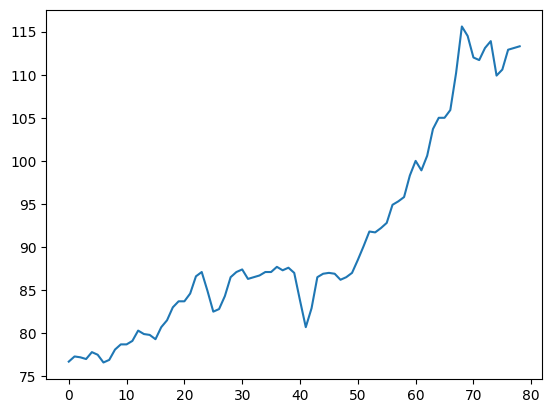

In [983]:
cpi["Transport"].plot()

In [1244]:
ph = model_table[best_model_table["Transport"]].fit(model.getExtraData(), cpi[['date','Transport']])

In [1245]:
model_table[best_model_table["Transport"]].predict([2])

array([113.3275388])

In [1246]:
ph = ph.model_

In [1262]:
future = ph.make_future_dataframe(periods=2, freq='MS')

In [1263]:
future

,ds
0,2018-01-01
1,2018-02-01
2,2018-03-01
3,2018-04-01
4,2018-05-01
...,...
62,2023-03-01
63,2023-04-01
64,2023-05-01
65,2023-06-01


In [1264]:

data = model.getExtraData()

data = data.rename(columns={'date':'ds'})
data['ds'] = pd.DatetimeIndex(data['ds'])

future = pd.merge(future,data,on='ds')

In [1265]:
future

,ds,fuel_price,sabor,fuel_offset_1,fuel_offset_3,USD/ZAR,GBP/ZAR,EUR/ZAR
0,2018-01-01,13.93,6.737957,14.27,13.52,12.197131,16.812471,14.852223
1,2018-01-01,13.93,6.737957,14.27,13.52,12.197131,16.812471,14.852223
2,2018-02-01,13.63,6.748950,13.93,13.56,11.818639,16.556277,14.617775
3,2018-03-01,13.27,6.732000,13.63,14.27,11.843666,16.529828,14.597329
4,2018-04-01,13.89,6.504286,13.27,13.93,12.067608,16.989794,14.818127
...,...,...,...,...,...,...,...,...
65,2023-02-01,20.73,7.211850,20.45,21.92,17.916716,21.611035,19.168071
66,2023-03-01,22.00,7.223304,20.73,22.51,18.264031,22.163418,19.565940
67,2023-04-01,21.92,7.713450,22.00,20.45,18.156630,22.598746,19.953257
68,2023-05-01,22.29,7.804391,21.92,20.73,19.089853,23.817278,20.761558


In [1254]:
forecast = ph.predict(future)

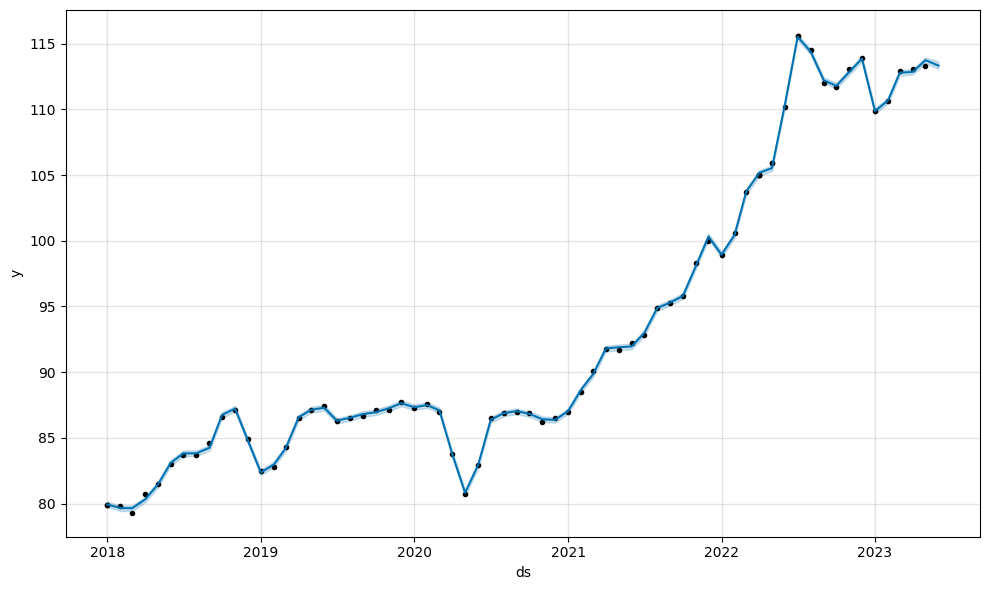

In [1255]:
fig = ph.plot(forecast)

<Axes: xlabel='ds'>

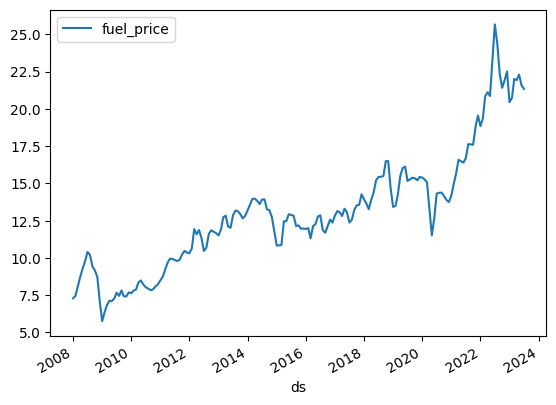

In [952]:
fuel_df2.set_index('ds', drop=True).plot()

In [999]:
fuel_df2['fuel_price']=(fuel_df2['fuel_price']-fuel_df2['fuel_price'].mean())/fuel_df2['fuel_price'].std()

<Axes: xlabel='ds'>

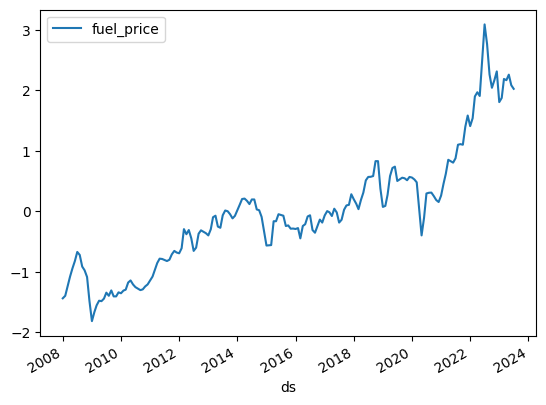

In [1000]:
fuel_df2.set_index('ds', drop=True).plot()

In [1004]:
fuel_df2['fuel_price'] = fuel_df2['fuel_price'].shift(1) - fuel_df2['fuel_price']

<Axes: xlabel='ds'>

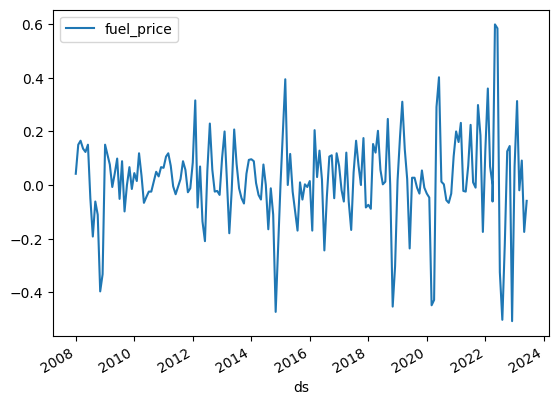

In [1006]:
fuel_df2.set_index('ds', drop=True).plot()

In [1251]:
forecast=(forecast-forecast.mean())/forecast.std()

In [1256]:
from prophet.plot import add_changepoints_to_plot
a = add_changepoints_to_plot(fig.gca(), ph, forecast)

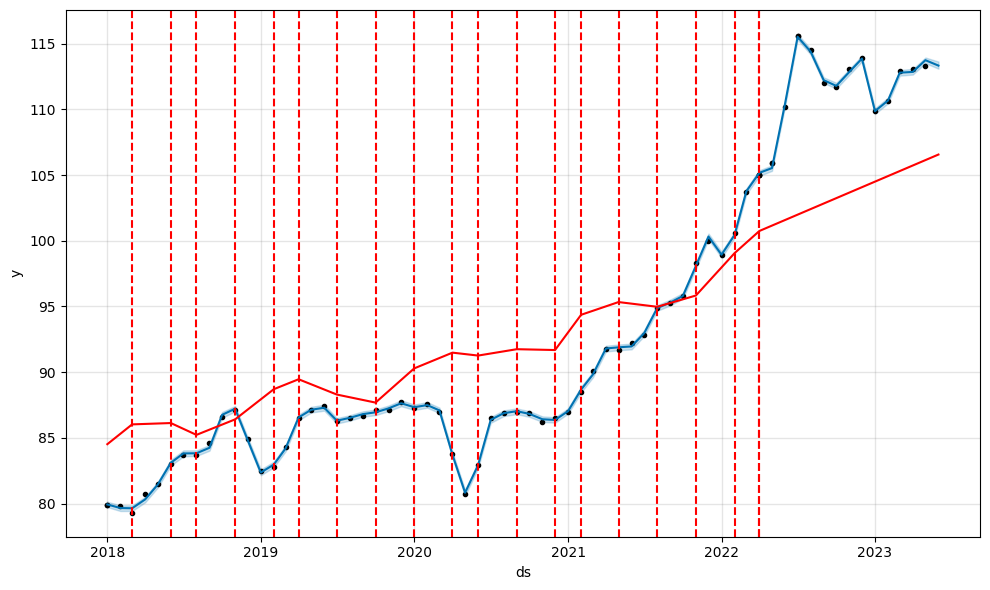

In [1257]:
fig

In [1258]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,EUR/ZAR,EUR/ZAR_lower,EUR/ZAR_upper,GBP/ZAR,...,sabor,sabor_lower,sabor_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,84.519206,79.733816,80.146939,84.519206,84.519206,-0.317827,-0.317827,-0.317827,1.673685,...,0.625471,0.625471,0.625471,-0.228436,-0.228436,-0.228436,0.0,0.0,0.0,79.933663
1,2018-01-01,84.519206,79.732626,80.141016,84.519206,84.519206,-0.317827,-0.317827,-0.317827,1.673685,...,0.625471,0.625471,0.625471,-0.228436,-0.228436,-0.228436,0.0,0.0,0.0,79.933663
2,2018-02-01,85.311366,79.432916,79.866387,85.311366,85.311366,-0.350223,-0.350223,-0.350223,1.822806,...,0.630439,0.630439,0.630439,-0.781602,-0.781602,-0.781602,0.0,0.0,0.0,79.660097
3,2018-03-01,86.026865,79.435627,79.861140,86.026865,86.026865,-0.353049,-0.353049,-0.353049,1.838201,...,0.622779,0.622779,0.622779,-0.915184,-0.915184,-0.915184,0.0,0.0,0.0,79.643646
4,2018-04-01,86.060883,80.094502,80.515781,86.060883,86.060883,-0.322538,-0.322538,-0.322538,1.570473,...,0.519877,0.519877,0.519877,-1.062470,-1.062470,-1.062470,0.0,0.0,0.0,80.318584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2023-02-01,104.920690,110.453036,110.893749,104.920690,104.920690,0.278550,0.278550,0.278550,-1.119364,...,0.839619,0.839619,0.839619,-0.646441,-0.646441,-0.646441,0.0,0.0,0.0,110.667417
66,2023-03-01,105.303003,112.562025,112.994605,105.303003,105.303003,0.333529,0.333529,0.333529,-1.440884,...,0.844795,0.844795,0.844795,-0.808707,-0.808707,-0.808707,0.0,0.0,0.0,112.788335
67,2023-04-01,105.726277,112.642629,113.076975,105.726277,105.726277,0.387049,0.387049,0.387049,-1.694271,...,1.066288,1.066288,1.066288,-1.094640,-1.094640,-1.094640,0.0,0.0,0.0,112.846371
68,2023-05-01,106.135898,113.513361,113.942115,106.135898,106.135898,0.498742,0.498742,0.498742,-2.403529,...,1.107383,1.107383,1.107383,-1.028059,-1.028059,-1.028059,0.0,0.0,0.0,113.738441


In [994]:
fuel_df2 = fuel_df.rename(columns={'date': 'ds'})
fuel_df2['ds'] = pd.DatetimeIndex(fuel_df2['ds'])

In [995]:
output = pd.merge(forecast,fuel_df2, on="ds")

ValueError: You are trying to merge on object and datetime64[ns] columns. If you wish to proceed you should use pd.concat

<Axes: >

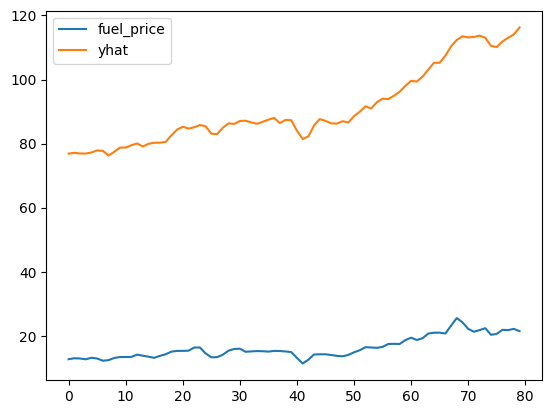

In [996]:
output[['fuel_price','yhat']].plot()

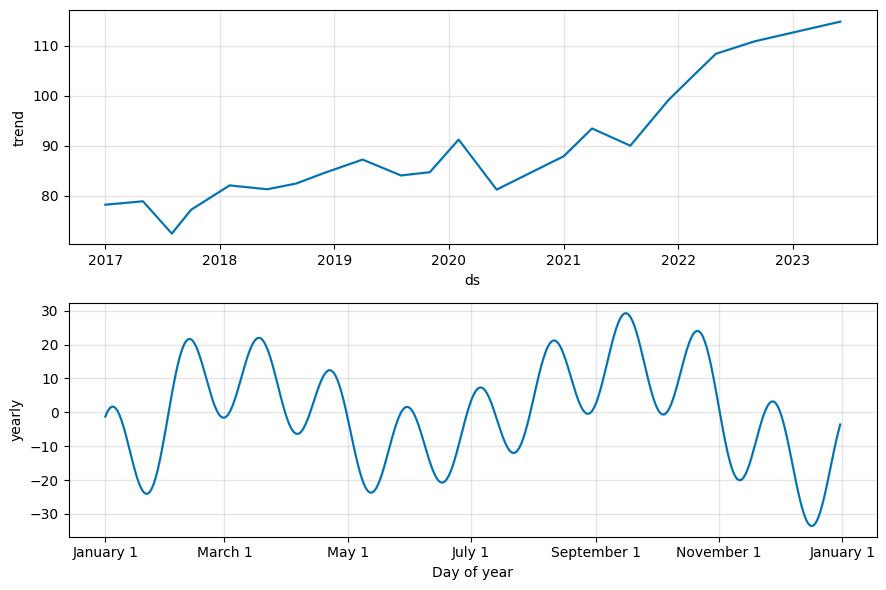

In [958]:
fig1 = ph.plot_components(forecast)

In [959]:
fuel_df

,date,fuel_price
0,2023-07,21.34
1,2023-06,21.58
2,2023-05,22.29
3,2023-04,21.92
4,2023-03,22.00
...,...,...
180,2008-05,9.29
181,2008-04,8.74
182,2008-03,8.07
183,2008-02,7.46


In [960]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,78.211492,75.987345,77.981846,78.211492,78.211492,-1.273631,-1.273631,-1.273631,-1.273631,-1.273631,-1.273631,0.0,0.0,0.0,76.937861
1,2017-02-01,78.389791,76.201811,78.135297,78.389791,78.389791,-1.227313,-1.227313,-1.227313,-1.227313,-1.227313,-1.227313,0.0,0.0,0.0,77.162478
2,2017-03-01,78.550836,75.925818,77.938551,78.550836,78.550836,-1.572053,-1.572053,-1.572053,-1.572053,-1.572053,-1.572053,0.0,0.0,0.0,76.978783
3,2017-04-01,78.729135,75.950200,77.888551,78.729135,78.729135,-1.782799,-1.782799,-1.782799,-1.782799,-1.782799,-1.782799,0.0,0.0,0.0,76.946336
4,2017-05-01,78.901683,76.250715,78.228890,78.901683,78.901683,-1.628937,-1.628937,-1.628937,-1.628937,-1.628937,-1.628937,0.0,0.0,0.0,77.272745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,2023-02-01,113.077759,109.174613,111.097170,113.077759,113.077759,-2.945627,-2.945627,-2.945627,-2.945627,-2.945627,-2.945627,0.0,0.0,0.0,110.132131
74,2023-03-01,113.481684,110.806644,112.853114,113.481684,113.481684,-1.604209,-1.604209,-1.604209,-1.604209,-1.604209,-1.604209,0.0,0.0,0.0,111.877475
75,2023-04-01,113.928887,111.984956,114.026545,113.928887,113.928887,-0.886551,-0.886551,-0.886551,-0.886551,-0.886551,-0.886551,0.0,0.0,0.0,113.042335
76,2023-05-01,114.361664,113.134246,114.983966,114.361664,114.361664,-0.273152,-0.273152,-0.273152,-0.273152,-0.273152,-0.273152,0.0,0.0,0.0,114.088512


In [961]:
print(str(ph.changepoint_prior_scale))

10.0
